# Analysis of business indicators

I am a marketing analyst, and I need to determine why the company has been experiencing losses over the past few months.

**Objective:** To analyze advertising expenses and their effectiveness, and based on this data, provide recommendations to the marketing agency.

**Available data:** Server logs with visit data, purchase records for the period, and advertising expenses.

**Work plan:**

1) Process the data and prepare it for analysis;

2) Examine customers segmented by country, device, and advertising source;

3) Calculate the money spent on each advertising source;

4) Evaluate the return on investment (ROI) of advertising segmented by region, device, and advertising source;

5) Calculate customer conversion and retention rates;

6) Draw a general conclusion.

## Data preparation

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits = visits.rename(columns={
    'User Id': 'user_id',
    'Region': 'region',
    'Device': 'device',
    'Channel': 'channel',
    'Session Start' : 'session_start',
    'Session End' : 'session_end'
})
orders = orders.rename(columns={
    'User Id': 'user_id',
    'Event Dt': 'event_dt',
    'Revenue': 'revenue'
})
costs = costs.rename(columns={
    'Channel': 'channel'
})

In [4]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [5]:
print(visits.isna().sum())
print()
print(orders.isna().sum())
print()
print(costs.isna().sum())

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

user_id     0
event_dt    0
revenue     0
dtype: int64

dt         0
channel    0
costs      0
dtype: int64


In [6]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


## Functions for calculating LTV, ROI, retention and conversion.

In [7]:
def get_profiles(sessions, orders, ad_costs):
 
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
 

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
 
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
 

    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
 
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
 

    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
 
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
 
    return profiles

In [8]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    dimensions = ['payer'] + dimensions

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

In [9]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result


    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)


    if 'cohort' in dimensions: 
        dimensions = []


    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )


    return result_raw, result_grouped, result_in_time

In [10]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  
        result_grouped,  
        result_in_time,  
        roi_grouped,  
        roi_in_time,  
    )

In [11]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [12]:
def plot_retention(retention, retention_history, horizon, window=7):

   
    plt.figure(figsize=(15, 10))

    
    retention = retention.drop(columns=['cohort_size', 0])
    
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')

    
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')

    
    ax3 = plt.subplot(2, 2, 3)
    
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title(
        'Retention dynamics of paying users on day {}'.format(
            horizon
        )
    )

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)

    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Acquisition date')
    plt.title(
        'Retention dynamics of paying users on day {}'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [13]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    
    plt.figure(figsize=(15, 5))

    
    conversion = conversion.drop(columns=['cohort_size'])
    
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('User conversion')

    
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('Retention dynamics of paying users on day {}'.format(horizon))

    plt.tight_layout()
    plt.show()

In [14]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('User LTV dynamics on day {}'.format(horizon))

    
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title('User acquisition cost dynamics')

    
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Acquisition date')
    plt.title('User ROI dynamics on day {}'.format(horizon))

    plt.tight_layout()
    plt.show()

## Research data analysis

In [15]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head())

    user_id            first_ts     channel  device         region         dt  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States 2019-05-07   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States 2019-07-09   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France 2019-10-01   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany 2019-08-22   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States 2019-10-02   

       month  payer  acquisition_cost  
0 2019-05-01   True          1.088172  
1 2019-07-01  False          1.107237  
2 2019-10-01  False          0.000000  
3 2019-08-01  False          0.988235  
4 2019-10-01  False          0.230769  


In [16]:
print(profiles['dt'].min())

2019-05-01 00:00:00


In [17]:
print(profiles['dt'].max())

2019-10-27 00:00:00


In [18]:
for_region = profiles.groupby('region').agg({'user_id' : 'count', 'payer' : 'sum'}).sort_values(by='user_id', ascending=False)
for_region = for_region.rename(columns={'user_id' : 'quantity'})
for_region['payer_percentage'] = round(for_region['payer'] / for_region['quantity'] * 100, 3)
print(for_region)

               quantity  payer  payer_percentage
region                                          
United States    100002   6902             6.902
UK                17575    700             3.983
France            17450    663             3.799
Germany           14981    616             4.112


In [19]:
for_device = profiles.groupby('device').agg({'user_id' : 'count', 'payer' : 'sum'}).sort_values(by='user_id', ascending=False)
for_device = for_device.rename(columns={'user_id' : 'quantity'})
for_device['payer_percentage'] = round(for_device['payer'] / for_device['quantity'] * 100, 3)
print(for_device)

         quantity  payer  payer_percentage
device                                    
iPhone      54479   3382             6.208
Android     35032   2050             5.852
PC          30455   1537             5.047
Mac         30042   1912             6.364


In [20]:
for_channel = profiles.groupby('channel').agg({'user_id' : 'count', 'payer' : 'sum'}).sort_values(by='user_id', ascending=False)
for_channel = for_channel.rename(columns={'user_id' : 'quantity'})
for_channel['payer_percentage'] = round(for_channel['payer'] / for_channel['quantity'] * 100, 3)
print(for_channel)

                    quantity  payer  payer_percentage
channel                                              
organic                56439   1160             2.055
FaceBoom               29144   3557            12.205
TipTop                 19561   1878             9.601
OppleCreativeMedia      8605    233             2.708
LeapBob                 8553    262             3.063
WahooNetBanner          8553    453             5.296
RocketSuperAds          4448    352             7.914
MediaTornado            4364    156             3.575
YRabbit                 4312    165             3.827
AdNonSense              3880    440            11.340
lambdaMediaAds          2149    225            10.470


## Marketing

In [21]:
round(costs['costs'].sum(), 1)

105497.3

In [22]:
costs_per_channel = costs.groupby('channel').agg({'costs' : 'sum'}).sort_values(by='costs', ascending=False)
print(costs_per_channel)

                       costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22


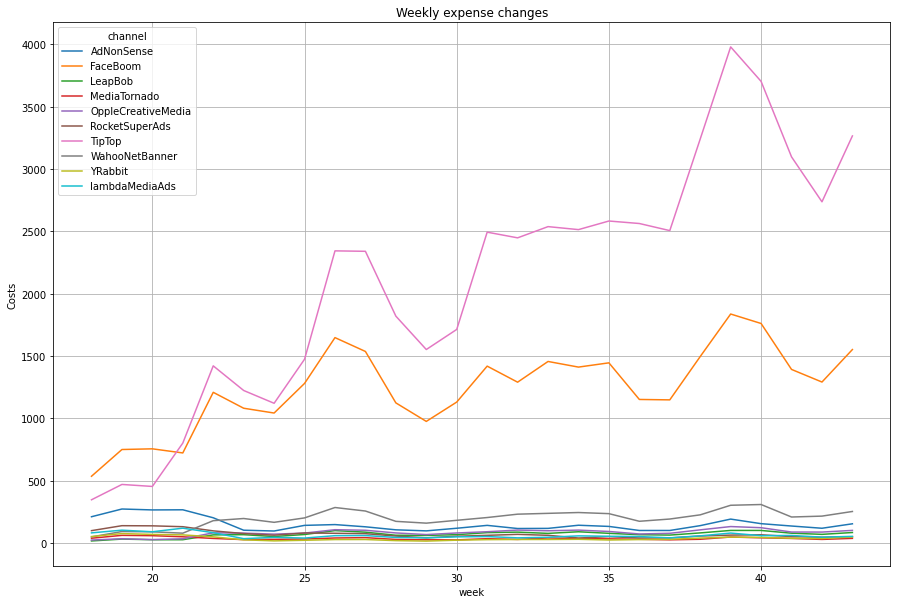

In [23]:
costs['week'] = costs['dt'].dt.isocalendar().week
costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum').plot(grid=True, figsize=(15, 10))
plt.title('Weekly expense changes')
plt.ylabel('Costs')
plt.show()

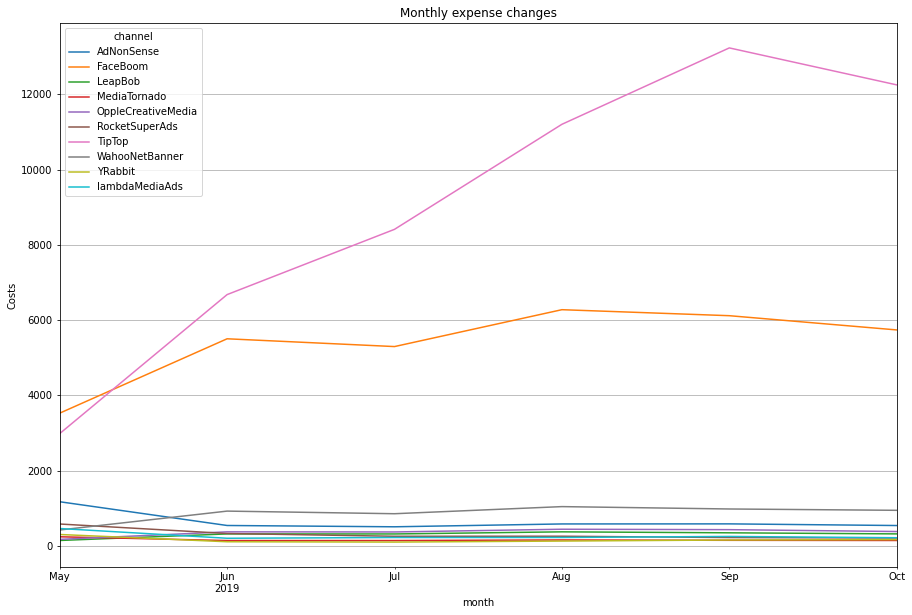

In [24]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot(grid=True, figsize=(15, 10))
plt.title('Monthly expense changes')
plt.ylabel('Costs')
plt.show()

In [25]:
user_costs = costs_per_channel.merge(right=for_channel, on='channel', how='left').drop(columns=['payer', 'payer_percentage'])
user_costs['costs_per_user'] = user_costs['costs']/user_costs['quantity']
user_costs['costs_per_user'] = round(user_costs['costs_per_user'], 3)
print(user_costs)

                       costs  quantity  costs_per_user
channel                                               
TipTop              54751.30     19561           2.799
FaceBoom            32445.60     29144           1.113
WahooNetBanner       5151.00      8553           0.602
AdNonSense           3911.25      3880           1.008
OppleCreativeMedia   2151.25      8605           0.250
RocketSuperAds       1833.00      4448           0.412
LeapBob              1797.60      8553           0.210
lambdaMediaAds       1557.60      2149           0.725
MediaTornado          954.48      4364           0.219
YRabbit               944.22      4312           0.219


## Payback of advertising

In [26]:
profiles = profiles[profiles['channel'] != 'organic']

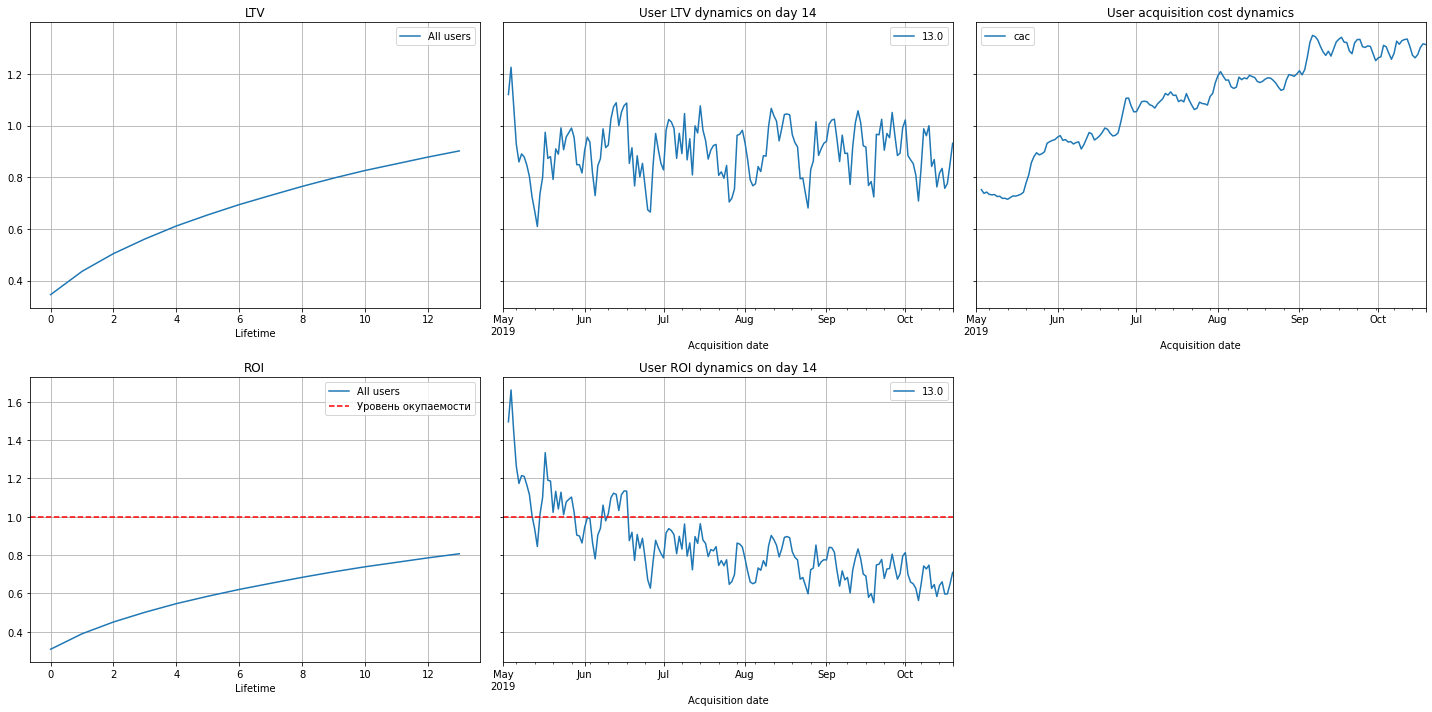

In [27]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, datetime(2019, 11, 1).date(), 14)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3)

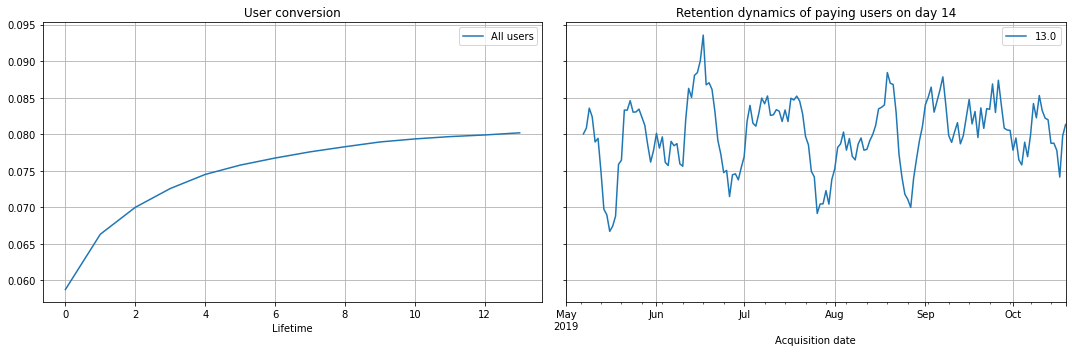

In [28]:
conversion_raw, conversion, conversion_history = get_conversion(profiles, orders, datetime(2019, 11, 1).date(), 14)
plot_conversion(conversion, conversion_history, 14, window=7)

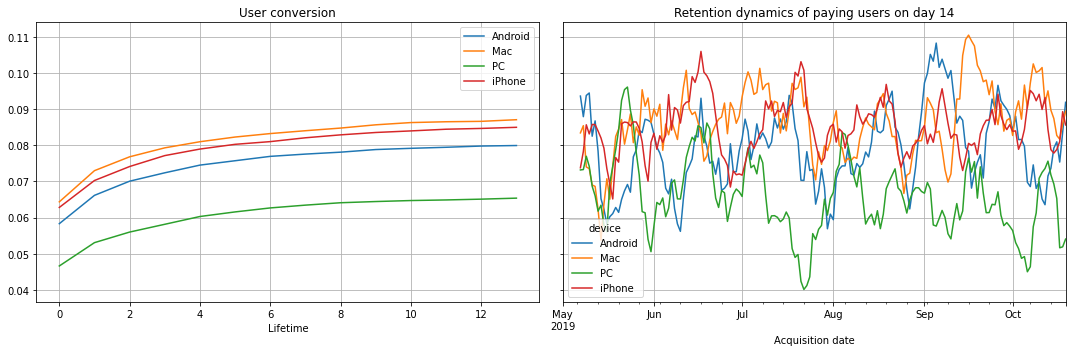

In [29]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)
plot_conversion(conversion, conversion_history, 14, window=7)

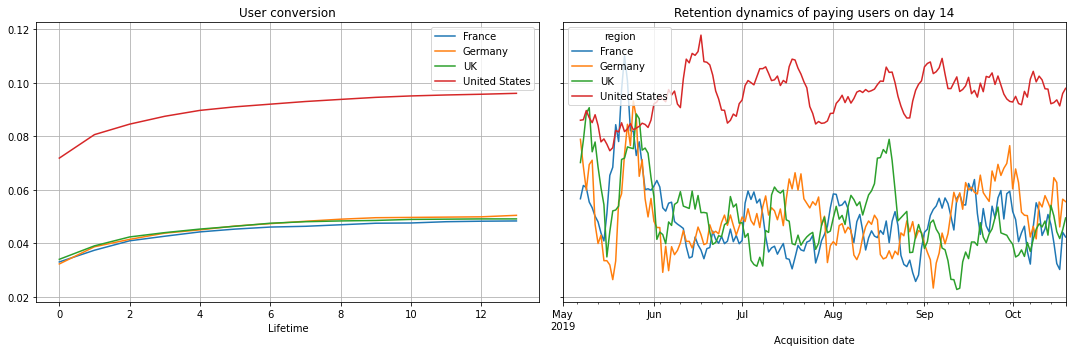

In [30]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)
plot_conversion(conversion, conversion_history, 14, window=7)

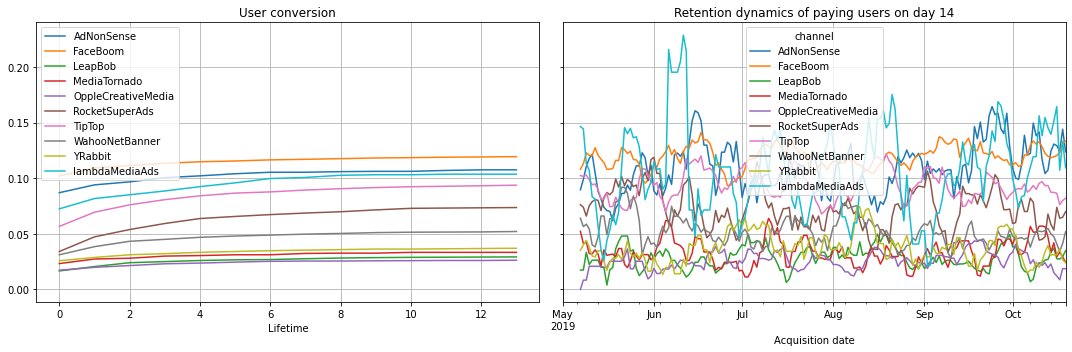

In [31]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)
plot_conversion(conversion, conversion_history, 14, window=7)

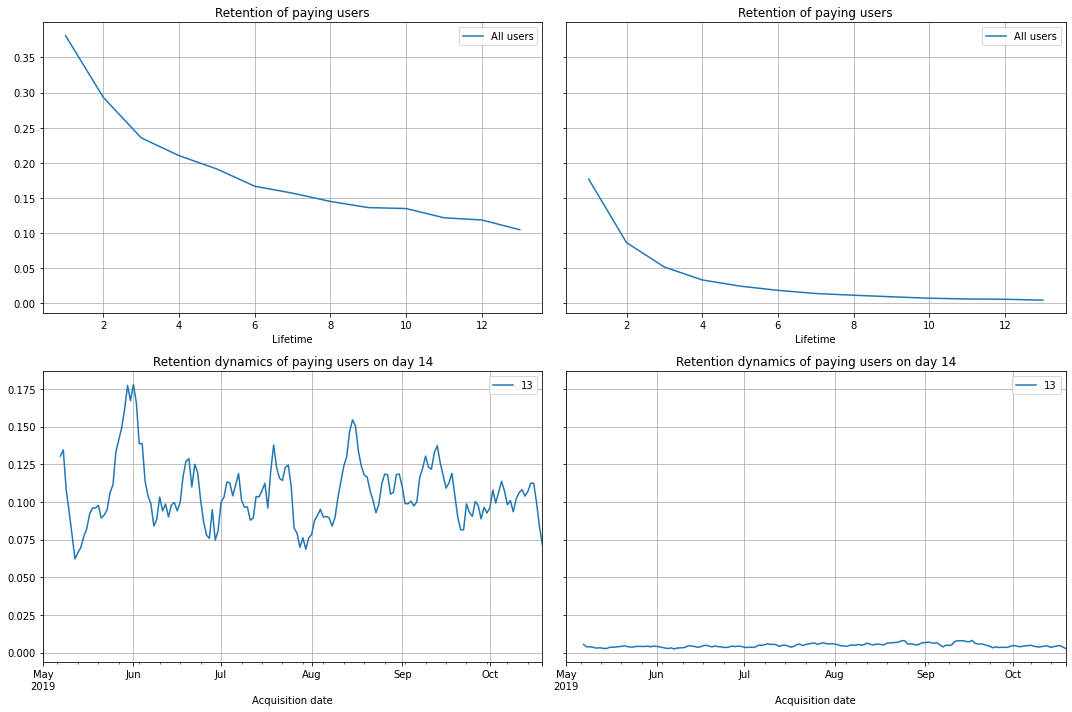

In [32]:
retention_raw, retention, retention_history = get_retention(profiles, visits, datetime(2019, 11, 1).date(), 14)
plot_retention(retention, retention_history, 14, window=7)

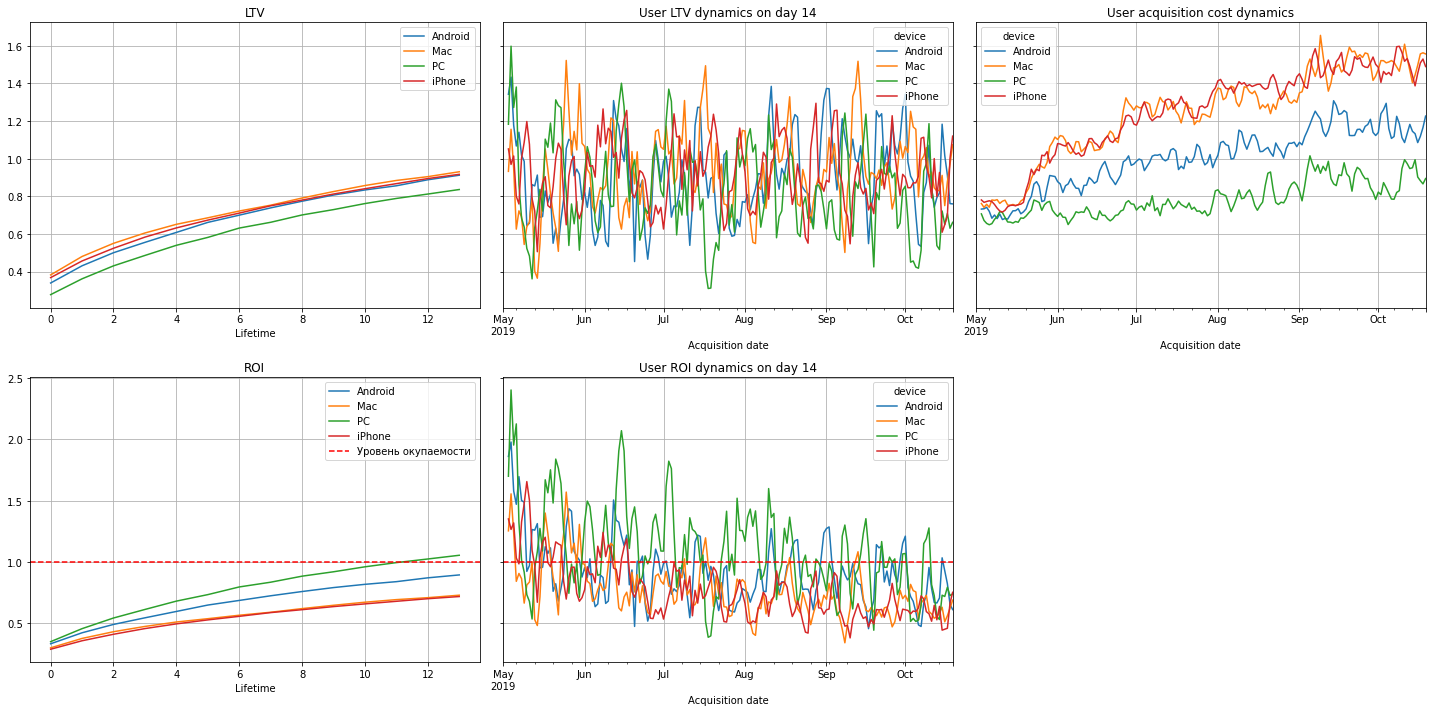

In [33]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3)

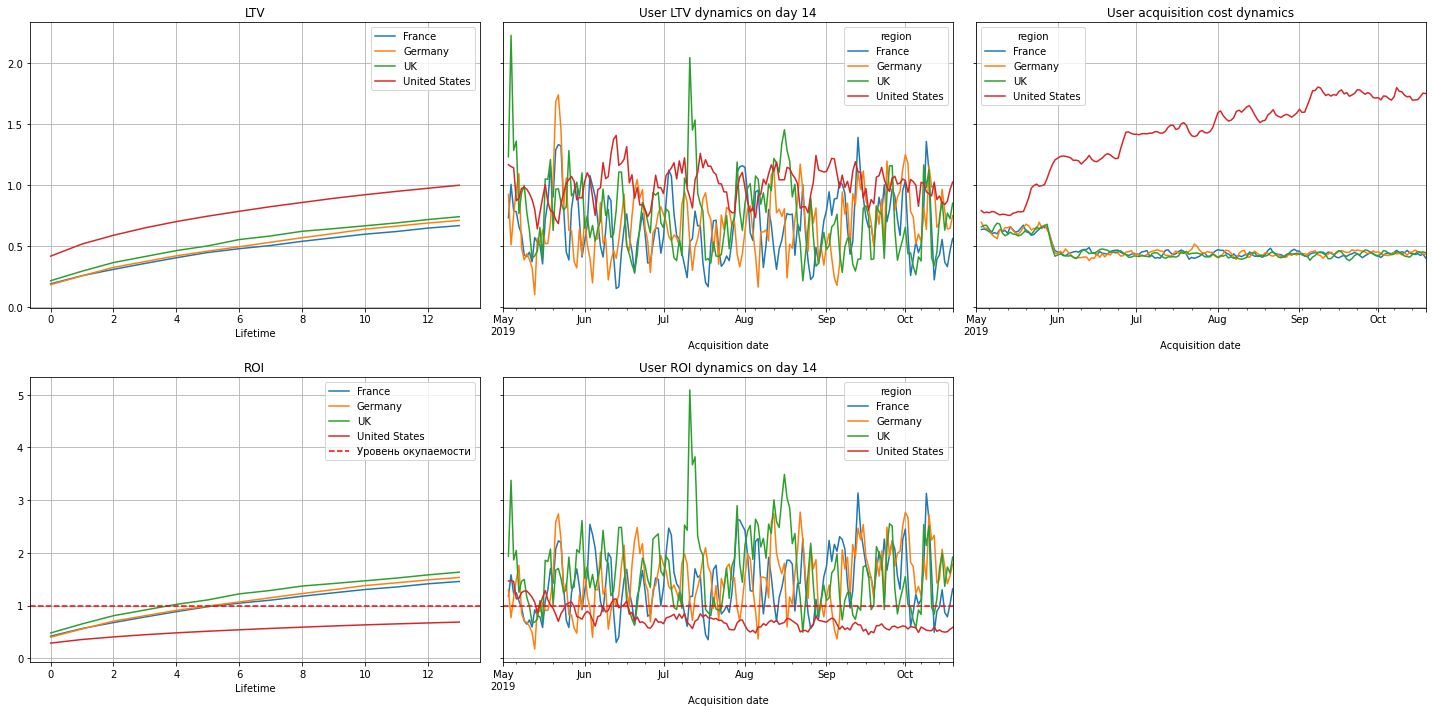

In [34]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3)

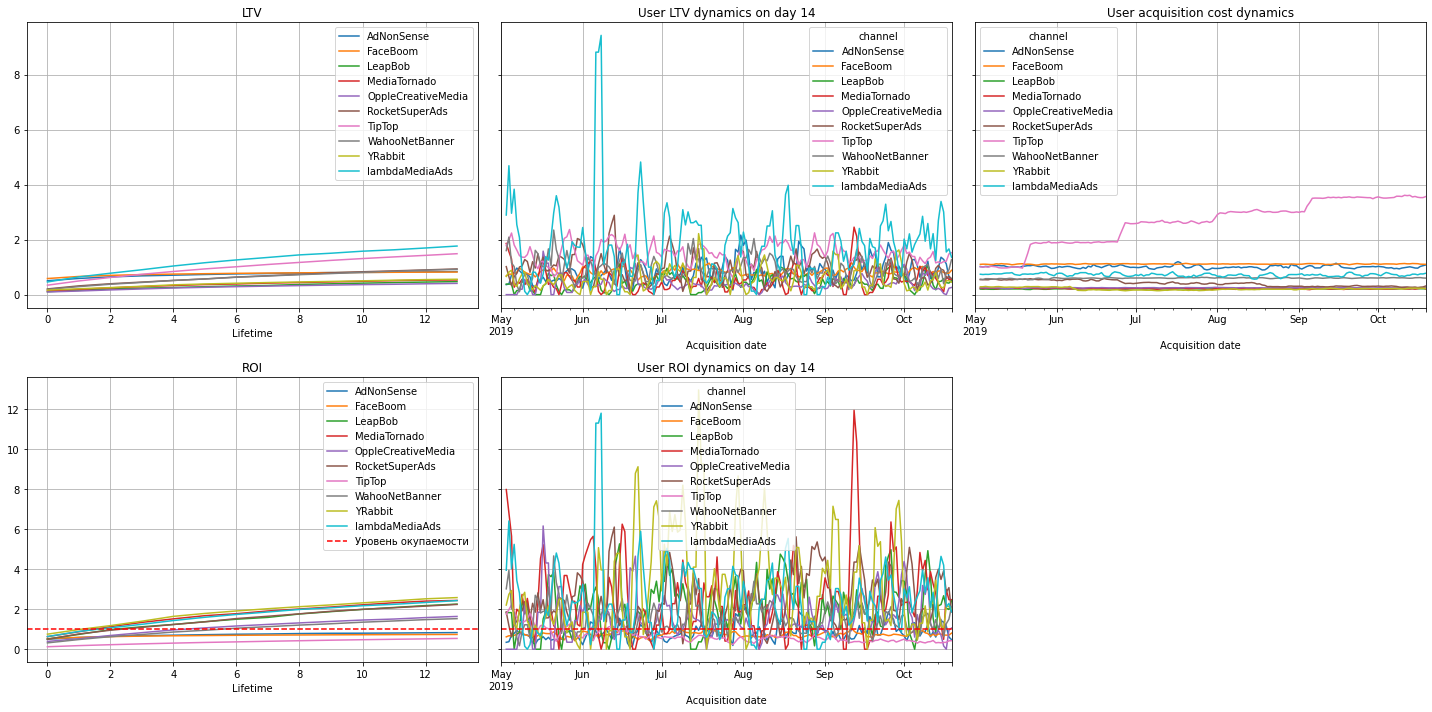

In [35]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3)

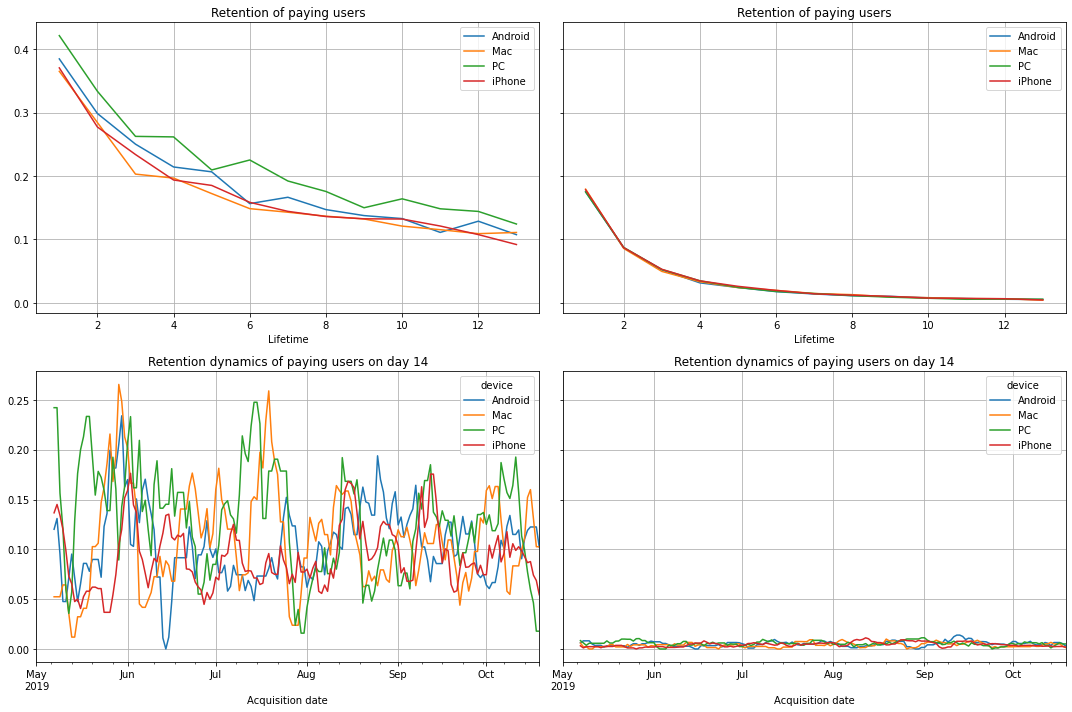

In [36]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)
plot_retention(retention, retention_history, 14, window=7)

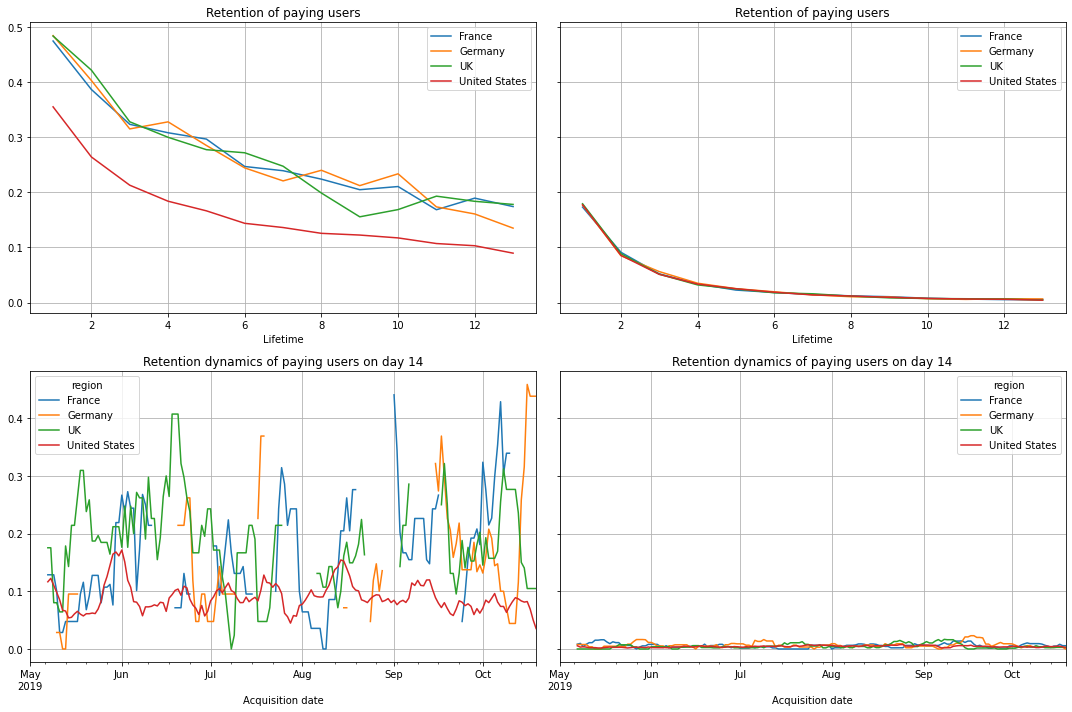

In [37]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)
plot_retention(retention, retention_history, 14, window=7)

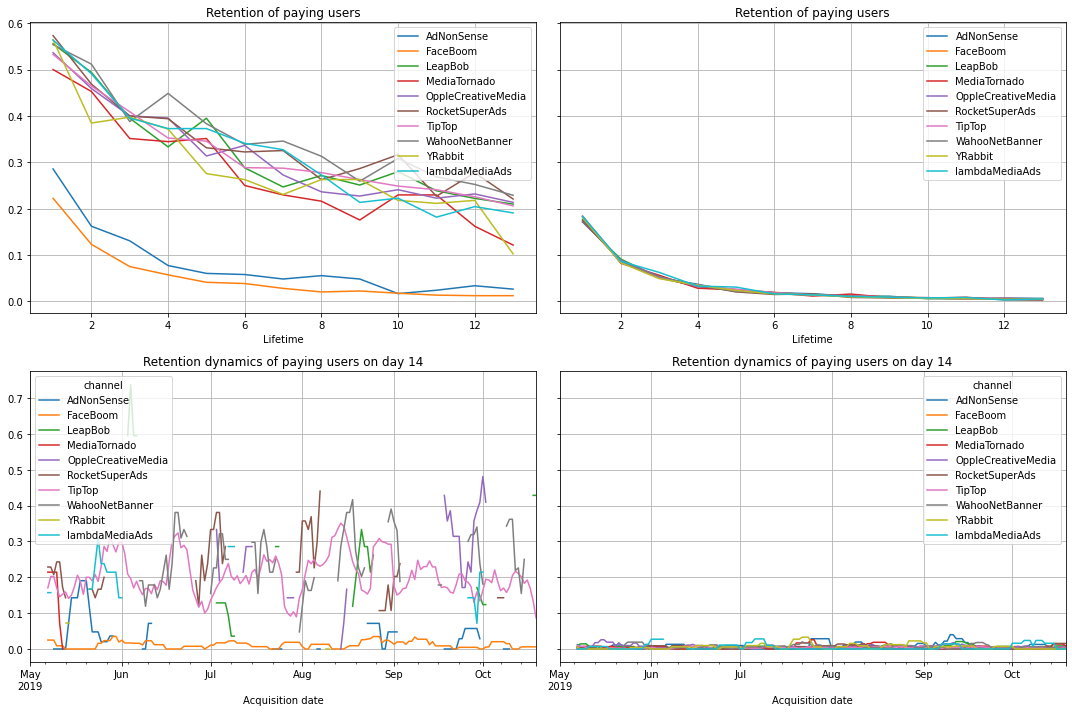

In [38]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)
plot_retention(retention, retention_history, 14, window=7)

## Conclusion

**Key Conclusions from My Work:**

* Customers from all devices except PCs are not profitable, as well as customers from the USA, and those acquired through TipTop, FaceBoom, and AdNoneSense.

* The retention rate for customers from the USA, as well as those acquired through FaceBoom and AdNoneSense, is too low.

* There is a high conversion rate for customers from the USA and those acquired through FaceBoom, AdNoneSense, and lambdaMediaAds.

In summary, it seems that the company has adopted an incorrect strategy for acquiring new customers. The main issue with profitability lies not in needing new customers, but rather in improving the retention of existing ones, especially those acquired from the most popular sources (FaceBoom, TipTop, and AdNoneSense) and from the USA. Therefore, the focus should be on customer retention in these areas. For other countries and sources, the emphasis should shift towards acquiring new customers. Sources like lambdaMediaAds, YRabbit, and RocketSuperAds are particularly promising, as they not only prove to be profitable but also demonstrate a high level of customer retention and a good conversion rate.